# Evaluate BART-CNN from Huggingface on the dataset CNN
* link1 : https://github.com/dhivyeshrk/FineTuning-Facebook-bart-large-cnn/blob/main/bart-large-cnn-finetune-for-textsummarization.ipynb
* link2 : https://huggingface.co/ainize/bart-base-cnn


In [1]:
import sys,os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch

from datasets import load_dataset
from datasets import load_from_disk

from rouge_score import rouge_scorer

from transformers import AutoTokenizer

In [2]:

NUM_PROCS = os.cpu_count() 
print("NUM_PROCS = " ,NUM_PROCS)

MODEL_HUB = "facebook/bart-large-cnn"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_PROCS =  12


In [3]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load Model and Tokenizer
tokenizer = BartTokenizer.from_pretrained(MODEL_HUB, clean_up_tokenization_spaces=True)
model = BartForConditionalGeneration.from_pretrained(MODEL_HUB)


In [4]:
nb_params = 0 
for param in model.parameters():
    if param.requires_grad:
        nb_params += param.numel()

print(f"Total learnable parameters: {nb_params:_}")

memory_in_bytes = nb_params * 4  # 4 octet per parameter (32-bit floats)
#memory_in_gb = memory_in_bytes * 1e-9
param_size_gb = memory_in_bytes / (1024 ** 3)  # Convert bytes to gigabytes

print(f"Model parameters memory usage: {param_size_gb:.2f} GB")

Total learnable parameters: 406_290_432
Model parameters memory usage: 1.51 GB


In [5]:
print(tokenizer.vocab_size)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.bos_token, tokenizer.bos_token_id)
print(tokenizer.eos_token,tokenizer.eos_token_id)
print(tokenizer.unk_token,tokenizer.unk_token_id)
print(tokenizer.model_max_length)
tokenizer

50265
<pad> 1
<s> 0
</s> 2
<unk> 3
1000000000000000019884624838656


BartTokenizer(name_or_path='facebook/bart-large-cnn', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}

# Load the dataset and analyse some sample 

In [10]:
# Load dataset (e.g., CNN/DailyMail)
#dataset = load_dataset("cnn_dailymail", "3.0.0", split='train')
# Load the saved dataset
dataset = load_from_disk('data/cnn_dailymail')


In [11]:
from IPython.display import display, HTML

def sample(dataset,nb_elt=1):
    assert nb_elt <= dataset.__len__()
    idx = np.random.choice(dataset.__len__(),nb_elt,replace=False)
    df_sample = dataset.select(idx).to_pandas().to_html()

    display(HTML(df_sample))


sample(dataset,3)


In [9]:
text =  dataset.select(np.random.choice(dataset.__len__(),1)).to_pandas().article.values[0]
print(text)


print(tokenizer)

print(tokenizer.tokenize(text))

source = tokenizer(text,return_tensors='pt')

print(source["input_ids"].squeeze(),source["attention_mask"].squeeze()) # .squeeze() to keel the batch dim 


(CNN) -- Two planes made emergency landings at Amsterdam Schiphol Airport at almost the same time Monday, the Dutch airport said. The first plane was a KLM flight departing en route to Milan, Italy. The flight reported a possible technical problem and asked to return. The plane was inspected by engineers, and passengers were waiting to depart, the airport said. The second emergency landing involved a Delta Air Lines plane. It was not immediately clear what prompted that plane to land. Initially, the airport said a fire caused the landing. But a military police official described the issue as one of "technical difficulties." Delta would only say the plane, from Amsterdam to Mumbai, made the landing for "precautionary measures." "The aircraft landed without incident, and passengers deplaned normally," the airline said in a statement. It was "nothing big," Robert Van Kappel of Schipol Military Police of the incident. Schiphol is one of Europe's busiest transit sites.
BartTokenizer(name_or

# Know the length distribution of articles an highlights

In [12]:
def len_distrib(batch):

    len_articles = []
    len_highlights = []
    
    # Prefix the "summarize: " instruction to each article (can be adjusted depending on your task)
    batch["article"] = ["summarize: " + article for article in batch["article"]]

    for article, highlight in zip(batch["article"], batch["highlights"]):
        len_articles.append(len(tokenizer(article, truncation=False)["input_ids"]))
        len_highlights.append(len(tokenizer(highlight, truncation=False)["input_ids"]))


    source = tokenizer(batch["article"],truncation=True, max_length=tokenizer.model_max_length)
    resume = tokenizer(batch["highlights"],truncation=True, max_length=tokenizer.model_max_length)

    return {
        'input_ids': source['input_ids'], 
        'input_mask': source['attention_mask'],
        'input_len': len_articles,
        'target_ids': resume['input_ids'], 
        'target_mask': resume['attention_mask'],
        'target_len': len_highlights
        }



# dataset = dataset.map(len_distrib,num_proc=NUM_PROCS,batched=True,batch_size=32)# Save the Hugging Face dataset
# dataset.save_to_disk('data/cnn_dailymail')
# print("Dataset saved successfully.")


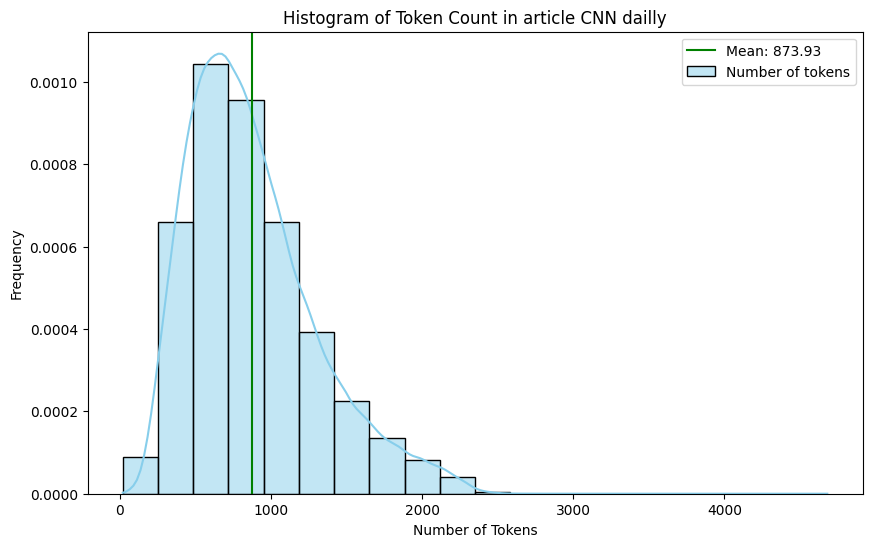

0.00% of texts have more than 1000000000000000019884624838656 tokens
max len  input_len    4681
dtype: int64


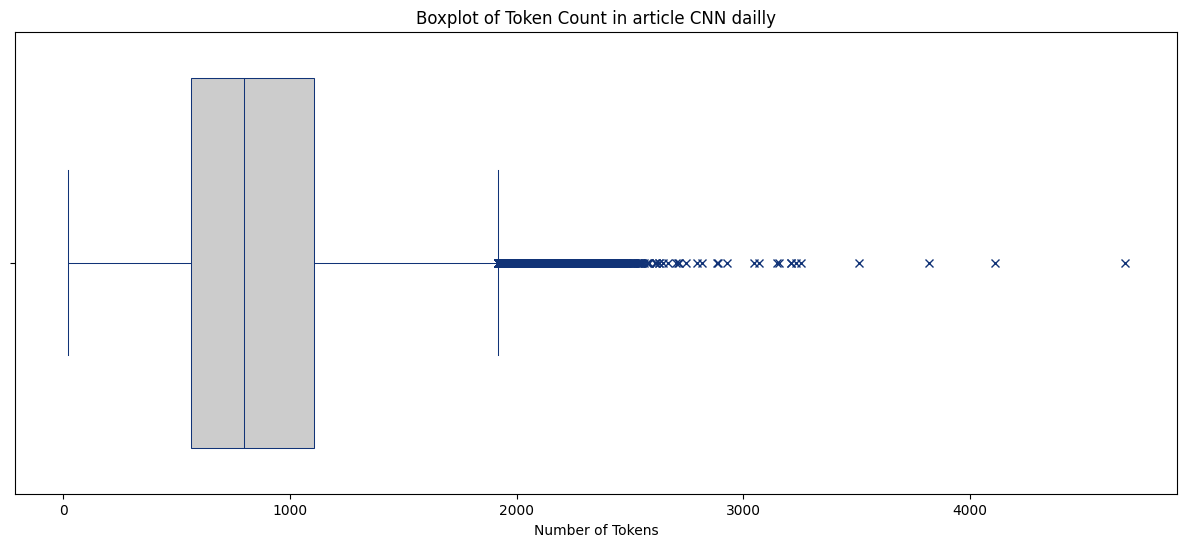

In [7]:

# Load input lengths into a DataFrame
article_inputs = pd.DataFrame({"input_len": dataset["input_len"]})

# Create the Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=article_inputs, x="input_len", bins=20, kde=True, color='skyblue', label='Number of tokens',stat="density")

# Calculate mean length
mean_length = article_inputs["input_len"].mean()

# Add vertical lines for max token and mean token length
#plt.axvline(x=tokenizer.model_max_length, color='r', linestyle='--', label=f'Max token: {tokenizer.model_max_length}')
plt.axvline(x=mean_length, color='g', linestyle='-', label=f'Mean: {mean_length:.2f}')

# Add title, labels, and legend
plt.title('Histogram of Token Count in article CNN dailly')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()

# Calculate and display the percentage of texts with more than 512 tokens
percentage_over = (article_inputs[article_inputs["input_len"] > tokenizer.model_max_length].count() / article_inputs.count()) * 100
print(f"{percentage_over['input_len']:.2f}% of texts have more than {tokenizer.model_max_length} tokens")
print("max len ", article_inputs.max())

# Create the Seaborn histogram
plt.figure(figsize=(15, 6))
sns.boxplot(data=article_inputs, x="input_len", showcaps=True,
    flierprops={"marker": "x"},
     color=".8", linecolor="#137", linewidth=.75)


# Add title, labels, and legend
plt.title('Boxplot of Token Count in article CNN dailly')
plt.xlabel('Number of Tokens')

# Display the plot
plt.show()

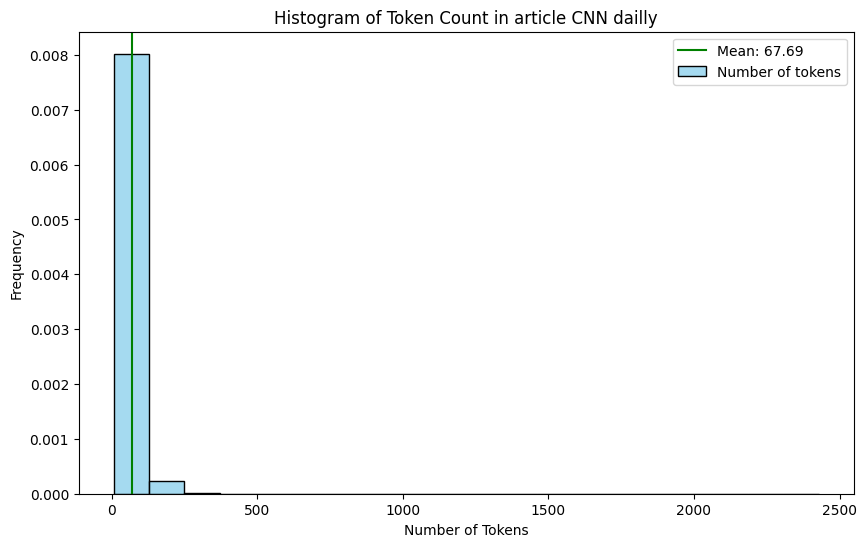

0.00% of texts have more than 1000000000000000019884624838656 tokens
max len  target_len    2428
dtype: int64


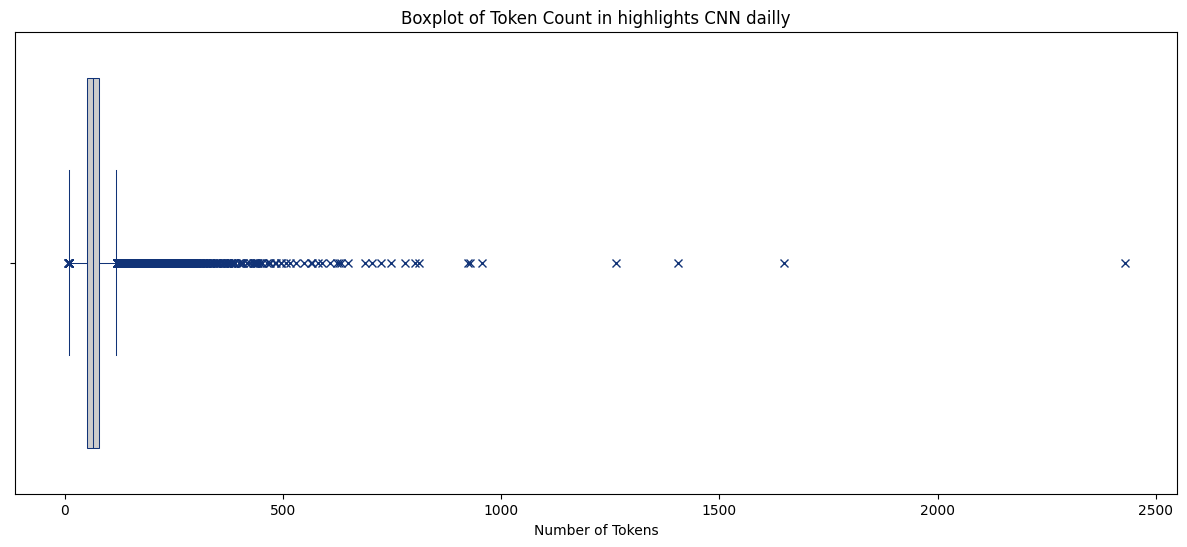

In [8]:

# Load input lengths into a DataFrame
target_inputs = pd.DataFrame({"target_len": dataset["target_len"]})

# Create the Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=target_inputs, x="target_len", bins=20, kde=False, color='skyblue', label='Number of tokens',stat="density")

# Calculate mean length
mean_length = target_inputs["target_len"].mean()

# Add vertical lines for max token and mean token length
#plt.axvline(x=tokenizer.model_max_length, color='r', linestyle='--', label=f'Max token: {tokenizer.model_max_length}')
plt.axvline(x=mean_length, color='g', linestyle='-', label=f'Mean: {mean_length:.2f}')

# Add title, labels, and legend
plt.title('Histogram of Token Count in article CNN dailly')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()

# Calculate and display the percentage of texts with more than max_tokens
percentage_over = (target_inputs[target_inputs["target_len"] > tokenizer.model_max_length].count() / target_inputs.count()) * 100
print(f"{percentage_over['target_len']:.2f}% of texts have more than {tokenizer.model_max_length} tokens")
print("max len ", target_inputs.max())

# Create the Seaborn histogram
plt.figure(figsize=(15, 6))
sns.boxplot(data=target_inputs, x="target_len", showcaps=True,
    flierprops={"marker": "x"},
     color=".8", linecolor="#137", linewidth=.75)


# Add title, labels, and legend
plt.title('Boxplot of Token Count in highlights CNN dailly')
plt.xlabel('Number of Tokens')

# Display the plot
plt.show()


# model weight visualisation 

## PCA on the embeddings layer 

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px

# Get the embedding layer
embedding_layer = model.get_input_embeddings().weight.detach().cpu().numpy()

# Apply PCA (reduce to 3 dimensions)
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embedding_layer)

# Create a DataFrame for easy plotting with token indices
embedding_df = pd.DataFrame({
    "PCA1": reduced_embeddings[:, 0],
    "PCA2": reduced_embeddings[:, 1],
    "PCA3": reduced_embeddings[:, 2],
    "Token Index": list(tokenizer.get_vocab().values())[:-1]  # Associate each point with a token index execpte the <MASK> token 
})

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(
    embedding_df,
    x="PCA1", y="PCA2", z="PCA3",
    color="PCA1",  # Optional: color based on one component
    hover_data={"Token Index": True},  # Show token index on hover
    title="3D PCA of BART-large-CNN Embedding Table",
    opacity=0.7,
    height=800
)

# Show the plot with zooming enabled
fig.update_traces(marker=dict(size=5))  # Adjust marker size for better visibility
fig.show()


## self_attention_weight distribution

In [52]:
for name, param in model.named_parameters():
    print(name)
    break 

model.get_encoder().layers[0].self_attn.k_proj.weight.shape




model.shared.weight


torch.Size([1024, 1024])

In [30]:
import tqdm 
weight = np.array([])
for name, param in model.named_parameters():
    if param.requires_grad and "self_attn" in name and "weight" in name:
        weight = np.concatenate([weight,param.clone().detach().cpu().numpy().flatten()])



In [32]:
# Global statistics
print(f"Global mean: {weight.mean():.6f}")
print(f"Global std: {weight.std():.6f}")
print(f"Global min: {weight.min():.6f}")
print(f"Global max: {weight.max():.6f}")

Global mean: 0.000145
Global std: 0.064618
Global min: -3.763672
Global max: 6.710938


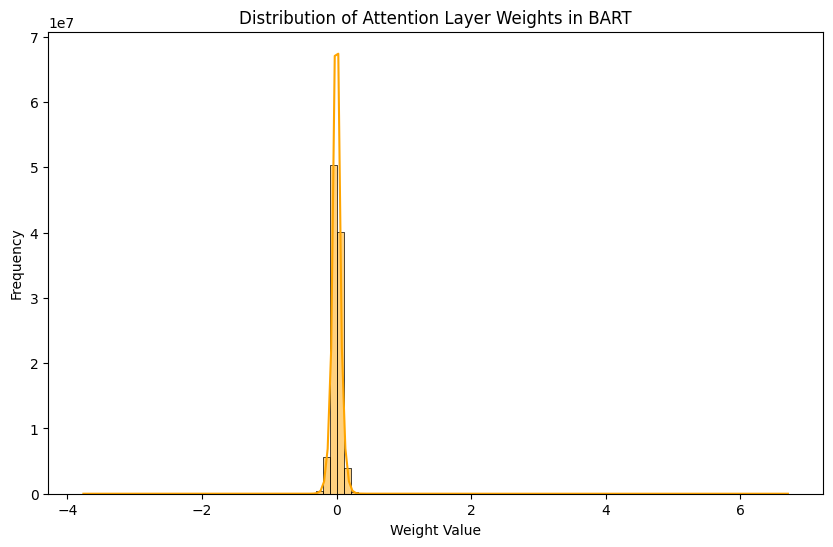

In [31]:

plt.figure(figsize=(10, 6))
sns.histplot(weight, bins=100, kde=True, color='orange')
plt.title('Distribution of Attention Layer Weights in BART')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.show()


# Rouge evaluation of the model Bart-CNN  

In [63]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

TRAIN_BATCH_SIZE =2

# Define the custom collate function
def collate_fn(batch):
    """
    Custom collate function that add padding for each batch.
    """

    # Pad the tokenized content
    padded_text_ids = pad_sequence(
        [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=tokenizer.pad_token_id)
    
    padded_text_mask = pad_sequence(
        [torch.tensor(item['input_mask'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=0)

    decoder_input_ids = pad_sequence(
        [torch.tensor(item['target_ids'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=tokenizer.pad_token_id)     
    
    decoder_attention_mask = pad_sequence(
        [torch.tensor(item['target_mask'], 
                      dtype=torch.long) for item in batch], 
                      batch_first=True, 
                      padding_value=0)
    

    return {
        'input_ids':padded_text_ids,
        'attention_mask':padded_text_mask,
        'decoder_input_ids':decoder_input_ids,
        'target_mask':decoder_attention_mask
    }


params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'collate_fn':collate_fn,
    'num_workers': NUM_PROCS
    }

# This will be used down for training and validation stage for the model.
loader = DataLoader(dataset, **params)

In [64]:
for batch in loader:
    print(batch)
    break

{'input_ids': tensor([[    0, 18581,  3916,  ...,     1,     1,     1],
        [    0, 18581,  3916,  ...,  1261,   479,     2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'decoder_input_ids': tensor([[    0,   863, 17864,    34,    57,  1593,    19,    70,    39,   623,
           968, 12535,    98,   444,   479, 50118,   387, 10074,  2627,     6,
          1156,     8,  8062,     6,    54,    70,   439,    66,    11,   826,
         11897,   479, 50118, 31004,  2071,   836,  3493,     9, 16651,  5482,
            11,  8700,  6399,     7, 34919,  7658,   479,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1],
        [    0, 17967,     9,   920,   164,   741,   268, 13760,    23,    10,
         11512,  1292,    11, 12388,   895,   281,  7048,     6,  1261,   479,
         50118, 42303, 38470,   918, 14169,     6, 35198,   388,     8, 13546,
             7,   478,   916,  

In [71]:
model.generate(batch["input_ids"])

tensor([[    2,     0, 35436,   154, 22219,   760,    12,   397,    34,    10,
          5070,    13,  6201,  2086,   893,     4,   344, 17864,    34,  4094,
           358,   165,    37,    34,  4094,    98,   444,    23,     5,   623,
           968,     4,  2910,   841,    33,  1146, 15736,     9,   344, 17864,
          7001,    11,    10,  8700,  6399,     4,    91,    16,   684,     7,
            28,    10,  2378,     9,  2910,   519,  5886, 16375,    10,   920,
            19,    10,  6606,  1421,     4,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1],
        [    2,     0,   250,   158,    12,   180,    12,   279,  2143,    34,
            57, 10571,   164,  2198,   741,   268, 13760,    11,    10,  1261,
         11512

In [ ]:
outputs = self.model(
   1643     input_ids,
   1644     attention_mask=attention_mask,
   1645     decoder_input_ids=decoder_input_ids,
   1646     encoder_outputs=encoder_outputs,
   1647     decoder_attention_mask=decoder_attention_mask,
   1648     head_mask=head_mask,
   1649     decoder_head_mask=decoder_head_mask,
   1650     cross_attn_head_mask=cross_attn_head_mask,
   1651     past_key_values=past_key_values,
   1652     inputs_embeds=inputs_embeds,
   1653     decoder_inputs_embeds=decoder_inputs_embeds,
   1654     use_cache=use_cache,
   1655     output_attentions=output_attentions,
   1656     output_hidden_states=output_hidden_states,
   1657     return_dict=return_dict,
   1658 )
   1660 lm_logits = self.lm_head(outputs[0])
   1661 lm_logits = lm_logits + self.final_logits_bias.to(lm_logits.device)


generate(
        self,
        inputs: Optional[torch.Tensor] = None,
        generation_config: Optional[GenerationConfig] = None,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        prefix_allowed_tokens_fn: Optional[Callable[[int, torch.Tensor], List[int]]] = None,
        synced_gpus: Optional[bool] = None,
        assistant_model: Optional["PreTrainedModel"] = None,
        streamer: Optional["BaseStreamer"] = None,
        negative_prompt_ids: Optional[torch.Tensor] = None,
        negative_prompt_attention_mask: Optional[torch.Tensor] = None,
        **kwargs,
    ) -> Union[GenerateOutput, torch.LongTensor]: